The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


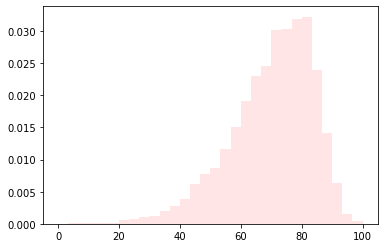

In [123]:
%load_ext autoreload
from ddls.distributions.distribution import Distribution

from typing import Union

from scipy.stats import skewnorm, rv_histogram
import numpy as np
import sigfig

import matplotlib.pyplot as plt

from __future__ import division
from scipy.stats import gaussian_kde

import random

numValues = 10000
maxValue = 100
skewness = -5   #Negative values are left skewed, positive values are right skewed.

random = skewnorm.rvs(a = skewness,loc=maxValue, size=numValues)  #Skewnorm function

random = random - min(random)      #Shift the set so the minimum value is equal to zero.
random = random / max(random)      #Standadize all the vlues between 0 and 1. 
random = random * maxValue         #Multiply the standardized values by the maximum value.

#Plot histogram to check skewness
plt.hist(random,30,density=True, color = 'red', alpha=0.1)
plt.show()

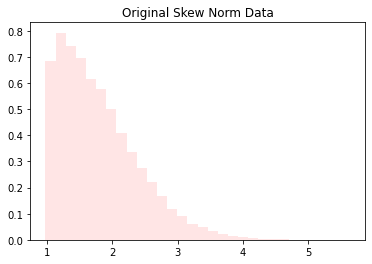

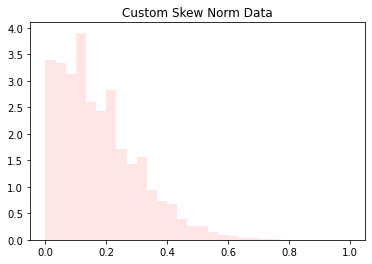

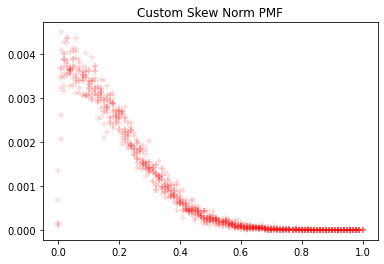

Sampled vals: [array([0.11, 0.37, 0.32, 0.03, 0.07, 0.04, 0.06, 0.06, 0.07, 0.12])]


In [127]:
%autoreload

class CustomSkewNorm(Distribution):
    def __init__(self,
                 skewness: Union[int, float],
                 min_val: Union[int, float],
                 max_val: Union[int, float],
                 decimals: int = 10,
                 accuracy_factor: int = 10,
                 num_bins=1000,
                 cutoff_mode: Union['min_val', 'resample'] = 'resample',
                 verbose: bool = False,
                ):
        '''
        This is a relatively hacky way of constructing a custom skew distribution. It uses
        the scipy skewnorm function to sample data, and then manipulates this data to fit
        the min, max, decimals etc values specified by the user. Finally, it generates a
        probability mass function (PMF) from the custom data by grouping the random variable
        values into num_bins. This last step is the most hacky, and there are more advanced
        KDE methods available (e.g. https://stackoverflow.com/questions/17821458/random-number-from-histogram)
        for generating a PMF from a histogram.
        
        Args:
            decimals: Number of decimal places to round random variable values to.If decimals is 
                negative, it specifies the number of positions to the left of the decimal point.
                E.g. decimals=-1 rounds to nearest 10, decimals=-2 rounds to nearest 100,
                decimals=1 rounds to nearest 0.1, etc.
            num_bins: Number of random variable values in the final PMF. Increase to ensure
                the PMF sampled from more closely resembles the continuous PDF of the
                original skew norm distribution. Decrease to reduce the time taken
                to instantiate this object.
            cutoff_mode: If min_val, any values less than min_val will be set to min_val in the
                final PMF. This can make distributions heavily skewed to the min_val if the skewness
                is too much. If resample, values less than min_val are re-sampled between min_val
                and max_val in a random uniform manner.
            verbose: If True, will plot and display graphs for each stage of the data 
                maniuplation when constructing the custom skew norm distribution.
        '''
        
        # initialise random var values sampled from a continuous skewed distribution
        if decimals > 0:
            # each subsequent random var value has min interval 0.<decimals>
            interval = 1 / (10**decimals)
        elif decimal < 0:
            # each subsequent random var value has min interval 10^(abs(decimals))
            interval = 10**(abs(decimals))
        else:
            # each subsequent random var value has min interval 1
            interval = 1
        size = int(max(50000, ((max_val - min_val) / interval)*accuracy_factor)) # use at least accuracy_factor samples per possible value to maintain dist accuracy
        skewnorm_random_var_vals = skewnorm.rvs(a=skewness, loc=max_val, size=size)
        if verbose:
            fig = plt.figure()
            plt.title('Original Skew Norm Data')
            plt.hist(skewnorm_random_var_vals, 30, density=True, color='red', alpha=0.1)
            plt.show()
        
        # begin manipulating skewnorm random var values
        random_var_vals = skewnorm_random_var_vals
        
        # shift to get min val as 0
        random_var_vals -= np.min(random_var_vals)
        
        # standardise between 0 and 1
        random_var_vals /= np.max(random_var_vals)
        
        # multiply by the specified max value to get the desired max value
        random_var_vals *= max_val
        
        # cut off values less than specified min val and set them to min val
        if cutoff_mode == 'min_val':
            random_var_vals = np.where(random_var_vals > min_val, random_var_vals, min_val)
        elif cutoff_mode == 'resample':
            random_var_vals = np.where(random_var_vals > min_val, random_var_vals, np.random.uniform(low=min_val, high=min_val))
        else:
            raise Exception(f'Unrecognised cutoff_mode {cutoff_mode}')
        
        if verbose:
            fig = plt.figure()
            plt.title('Custom Skew Norm Data')
            plt.hist(np.around(random_var_vals, decimals=decimals), 30, density=True, color='red', alpha=0.1)
            plt.show()
        
        # generate discrete probability dist with var values rounded to specified decimal places
        hist_counts, bin_vals = np.histogram(random_var_vals, bins=num_bins)
        self.random_var_vals = np.around(bin_vals[1:], decimals=decimals)
        self.random_var_probs = hist_counts / np.sum(hist_counts)
        
        if verbose:
            fig = plt.figure()
            plt.title('Custom Skew Norm PMF')
            plt.scatter(self.random_var_vals, self.random_var_probs, alpha=0.15, marker='+', color='red')
            plt.show()
    
    def sample(self,
               size: Union[None, int] = None,
               replace: bool = True):
        return np.random.choice(
                            self.random_var_vals,
                            p=self.random_var_probs,
                            size=size,
                            replace=replace,
                        )
    
np.random.seed(0) # TODO TEMP
custom_skew_norm = CustomSkewNorm(skewness=100, min_val=0, max_val=1, decimals=2, verbose=True)
sampled_vals = [custom_skew_norm.sample(10)]
print(f'Sampled vals: {sampled_vals}')

In [122]:
%autoreload
from ddls.distributions.uniform import Uniform

uniform = Uniform(min_val=0.1, max_val=1, decimals=2)
print(uniform.random_var_vals)
sampled_vals = uniform.sample(10)

[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51
 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65
 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79
 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93
 0.94 0.95 0.96 0.97 0.98 0.99 1.  ]
[0.23 0.97 0.92 0.88 0.84 0.94 0.6  0.33 0.58 0.62]
